In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [49]:
import os
import math
import numpy as np
import pandas as pd
import time
import string
import random
import sys
from logger import Logger
from abc import ABC
from datetime import timedelta
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
#from selection_strategy    import RandomSelectionStrategy
sys.path.insert(0,os.pardir)
from ga_inverse import readData
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
import matplotlib.pyplot as plt

In [15]:
from abc import ABC

class SelectionStrategy(ABC):
    def select_next_instance():
        pass

class RandomSelectionStrategy(SelectionStrategy):
    def __init__(self):
        pass
        #self.logPrefix = "Random Selection Strategy"

    def select_next_instance(self, candidate_instances: pd.DataFrame):
        selected = np.random.choice(candidate_instances, size=1, replace=False)[0]
        #self.logger.info(self.logPrefix, "Randomly Selected Zif: " + selected)
        return selected   

In [4]:
def plot_data_exists(data_path) -> bool:

    """ Check wheather plot data already exist and return the respective truth value.
        data_path1:     The path to look for the set of data."""

    if not os.path.exists(data_path):
        return False

    return True

def data_preparation(sourceFile=None, research_data="zifs_diffusivity") -> list:

    Y = []
    X = []

    if research_data == "zifs_diffusivity":
        if sourceFile is not None:
            data_from_file = readData(sourceFile)
        else:
            data_from_file = readData()

        Y = ["logD"]
        X = ['diameter','mass','ascentricF', 'kdiameter','ionicRad',
            'MetalNum','MetalMass','σ_1', 'e_1',
            'linker_length1', 'linker_length2', 'linker_length3',
            'linker_mass1', 'linker_mass2', 'linker_mass3',
            'func1_length', 'func2_length', 'func3_length', 
            'func1_mass', 'func2_mass', 'func3_mass']
    
    elif research_data == "co2":
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={'CO2_working_capacity(mol/kg)':'working_capacity', 'mof_name':'type'})

        # One Hot Encode Data
        features = ["Nodular_BB1", "Nodular_BB2", "Connecting_BB1", "Connecting_BB2"]
        data_from_file = pd.get_dummies(data_from_file, columns=features,dtype=int)

        Y = ["working_capacity"]
        X = [feature_label for base_label in features for feature_label in list(data_from_file.columns) if base_label in feature_label]

    elif research_data == "o2_n2":
        data_from_file = pd.read_csv(sourceFile)

        Y = ["logSelfD"]
        X = ['LCD',	'PLD',	'LFPD',	'Volume',	'ASA_m2_g',	
             'ASA_m2_cm3',	'NASA_m2_g', 'NASA_m2_cm3',	
             'AV_VF',	'AV_cm3_g',	'NAV_cm3_g', ' H', 'C',	'N', 'metal type', 
             ' total degree of unsaturation', 'metalic percentage',	' oxygetn-to-metal ratio',	
             'electronegtive-to-total ratio', ' weighted electronegativity per atom', 
             ' nitrogen to oxygen ', 'mass',	'ascentricF',	'diameter',	'kdiameter']

    else:
        data_from_file = pd.read_csv(sourceFile)
        data_from_file = data_from_file.rename(columns={' absolute methane uptake high P [v STP/v]':'methane_uptake', ' name':'type'})        

        Y = ['methane_uptake']
        X = ['dimensions', ' supercell volume [A^3]', ' density [kg/m^3]',
             ' surface area [m^2/g]', ' num carbon', ' num hydrogen',
             ' num nitrogen', ' num oxygen', ' num sulfur', ' num silicon',
             ' vertices', ' edges', ' genus', ' largest included sphere diameter [A]',
             ' largest free sphere diameter [A]', ' largest included sphere along free sphere path diameter [A]']

    return data_from_file, X, Y

In [61]:
np_data, featureNames, targetNames = data_preparation("../train_data/train_zifs_diffusivity/TrainData.xlsx")

# Instantiate the XGB regressor model
XGBR = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                        random_state=6410)

In [ ]:
### Bootstraping for estimating confidence 
def train_ensemble(X, y, n_models=10):
    models = []
    for i in range(n_models):
        # Bootstrap sampling
        X_sample, y_sample = resample(X, y)
        model = xgb.XGBRegressor(n_estimators=100, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                        random_state=(6410+i))
        model.fit(X_sample, y_sample)
        models.append(model)
    return models

def predict_with_ensemble(models, X):
    predictions = np.array([model.predict(X) for model in models])
    mean_prediction = np.mean(predictions, axis=0)
    std_prediction = np.std(predictions, axis=0)
    return mean_prediction, std_prediction

def uncertainty_sampling(models, X_unlabeled, k=1):
    _, std_prediction = predict_with_ensemble(models, X_unlabeled)
    # Select the top k most uncertain samples
    #uncertain_indices = std_prediction.argsort()[-k:]
    return std_prediction #uncertain_indices

In [6]:
### GP uncertainty
def Gp_uncertainty(X_train,y_train,X_unlabeled,featureNames):
    x_unlabeled = X_unlabeled[featureNames].to_numpy()
    # Define GP surrogate
    gp_model = GaussianProcessRegressor(kernel=RationalQuadratic(length_scale=1.0, alpha=1.5))
    gp_model.fit(X_train,y_train.ravel())
    y_pred, y_std = gp_model.predict(x_unlabeled,return_std=True)

    uncertainties = y_std #.argsort()[-1:]
    return uncertainties

In [31]:
class OptimizationFactory(ABC):
    def optimizeModel():
        pass

class ActiveLearning(OptimizationFactory):

    # def __init__(self):
    #     self.logPrefix = "Active Learning"

    def optimizeModel(self, model : any, zifs : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, bo_selection : str, save_path : str) -> pd.DataFrame:
        

        np.random.seed(10)
        optimization_start_time = time.time()

        # Make a list with all unique ZIF names.
        uniqueZIFs = zifs.type.unique()

        # Initialize dictionary of errors per training data size

        fold_num = 10
        design_space = (len(uniqueZIFs))
        fold_design_space = len(uniqueZIFs) * ((fold_num - 1) / fold_num)

        select_data_points_num = 0
        if design_space < designspace_thres:
            fold_num = len(uniqueZIFs)
            select_data_points_num = len(uniqueZIFs) - 1

        elif fold_design_space < designspace_thres:
            select_data_points_num = int(fold_design_space)

        else:
            select_data_points_num = designspace_thres

        # print(design_space)
        # print(fold_design_space)
        # print(select_data_points_num)

        zif_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=10)
        inner_round = 0 
        
        maePerTrainSize = {}

        for train_zif_indicies, left_out_zif_indicies in zif_kfold.split(uniqueZIFs):
            inner_round += 1
            #roundPath = os.path.join(save_path, "Round_" + str(inner_round))
            #os.mkdir(roundPath)
            print(train_zif_indicies.shape)
            print(left_out_zif_indicies)
            roundMae = []

            trainZIFnames = np.delete(uniqueZIFs, left_out_zif_indicies)
            testZIFname   = uniqueZIFs[left_out_zif_indicies]

            trainZIFs = zifs[~zifs['type'].isin(testZIFname)]
            testZIFs  = zifs[zifs['type'].isin(testZIFname)]
            
            
            selectRandomSample = 0
            currentData   = pd.DataFrame()

            maeBestPerformanceList      = []
            maeStopCriterionMet         = False
            bestPerformingData          = {}
            
            for sizeOfTrainZIFs in range(select_data_points_num):

                if selectRandomSample < 5:
                    # Sample 5 random ZIFs.
                    randomSelection = RandomSelectionStrategy()
                    randomZifName = randomSelection.select_next_instance(trainZIFnames)
                    selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]

                    # Remove the sellected ZIF from the list of available for training
                    trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                    trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))

                    selectRandomSample += 1

                else:
                    
                    # # Train the ensemble of models
                    # model_ensemble = train_ensemble(x_trainAll, y_trainAll, n_models=5)
                    # Select most uncertain data point
                    uncertainties = Gp_uncertainty(x_trainAll, y_trainAll,trainZIFs,X_featureNames)
                    selected_name = trainZIFs.iloc[np.argmax(uncertainties)]["type"]
                    selectedZIF = trainZIFs[(trainZIFs['type'] == selected_name)]
                    
                    # Remove the sellected ZIF from the list of available for training
                    trainZIFs = trainZIFs[(trainZIFs['type']) != selected_name]
                    trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == selected_name))

                # Add the next ZIF to the currently used data.
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                
                if(trainLength>=5):

                    # Train XGboost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Prediction on outer leave one out test data
                    x_test  = testZIFs[X_featureNames].to_numpy()
                    y_test  = testZIFs[Y_featureNames].to_numpy()

                    y_pred = model.predict(x_test)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    
                    print("Round",inner_round,"train size",sizeOfTrainZIFs,"mae is",mae)
  

                    if (sizeOfTrainZIFs + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainZIFs + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainZIFs + 1)].append(mae)
        
        print(maePerTrainSize.keys())    
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df


    



In [26]:
class RandomSampling(OptimizationFactory):

    # def __init__(self):
    #     self.logPrefix = "Active Learning"

    def optimizeModel(self, model : any, zifs : pd.DataFrame, X_featureNames : list, Y_featureNames : list , designspace_thres : int, bo_selection : str, save_path : str) -> pd.DataFrame:
        

        np.random.seed(10)
        optimization_start_time = time.time()

        # Make a list with all unique ZIF names.
        uniqueZIFs = zifs.type.unique()

        # Initialize dictionary of errors per training data size

        fold_num = 10
        design_space = (len(uniqueZIFs))
        fold_design_space = len(uniqueZIFs) * ((fold_num - 1) / fold_num)

        select_data_points_num = 0
        if design_space < designspace_thres:
            fold_num = len(uniqueZIFs)
            select_data_points_num = len(uniqueZIFs) - 1

        elif fold_design_space < designspace_thres:
            select_data_points_num = int(fold_design_space)

        else:
            select_data_points_num = designspace_thres

        print(design_space)
        print(fold_design_space)
        print(select_data_points_num)

        
        zif_kfold = KFold(n_splits=fold_num, shuffle=True, random_state=10)
        inner_round = 0 
        maePerTrainSize = {}

        for train_zif_indicies, left_out_zif_indicies in zif_kfold.split(uniqueZIFs):
            inner_round += 1
            #roundPath = os.path.join(save_path, "Round_" + str(inner_round))
            #os.mkdir(roundPath)
            
            roundMae = []

            trainZIFnames = np.delete(uniqueZIFs, left_out_zif_indicies)
            testZIFname   = uniqueZIFs[left_out_zif_indicies]

            trainZIFs = zifs[~zifs['type'].isin(testZIFname)]
            testZIFs  = zifs[zifs['type'].isin(testZIFname)]
            
            
            selectRandomSample = 0
            currentData   = pd.DataFrame()

            maeBestPerformanceList      = []
            maeStopCriterionMet         = False
            bestPerformingData          = {}
            
            for sizeOfTrainZIFs in range(select_data_points_num):

                
                # Sample 5 random ZIFs.
                randomSelection = RandomSelectionStrategy()
                randomZifName = randomSelection.select_next_instance(trainZIFnames)
                selectedZIF  = trainZIFs[(trainZIFs['type'] == randomZifName)]

                # Remove the sellected ZIF from the list of available for training
                trainZIFs     = trainZIFs[(trainZIFs['type']) != randomZifName]
                trainZIFnames = np.delete(trainZIFnames, np.where(trainZIFnames == randomZifName))

                # Add the next ZIF to the currently used data.
                currentData = pd.concat([currentData, selectedZIF], axis=0, ignore_index=True)

                # Create feature matrices for all currently used data.
                x_trainAll = currentData[X_featureNames].to_numpy()
                y_trainAll = currentData[Y_featureNames].to_numpy()

                currentBatchNames = currentData.type.unique()
                trainLength = len(currentBatchNames)
                
                if(trainLength>=5):

                    # Train XGboost with the updated dataset 
                    model.fit(x_trainAll, y_trainAll.ravel())
                    
                    # Prediction on outer leave one out test data
                    x_test  = testZIFs[X_featureNames].to_numpy()
                    y_test  = testZIFs[Y_featureNames].to_numpy()

                    y_pred = model.predict(x_test)
                    
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    
                    print("Round",inner_round,"train size",sizeOfTrainZIFs,"mae is",mae)
  

                    if (sizeOfTrainZIFs + 1) not in maePerTrainSize.keys():
                        maePerTrainSize[(sizeOfTrainZIFs + 1)] = []

                          
                    # Append mae to the corresponding dictionary list
                    maePerTrainSize[(sizeOfTrainZIFs + 1)].append(mae)
        
        print(maePerTrainSize.keys())    
        result_df = pd.DataFrame()
        result_df["sizeOfTrainingSet"]       = np.array([iCnt for iCnt in sorted(maePerTrainSize.keys()) ])
        result_df["averageError"]            = [ np.array(maePerTrainSize[iCnt]).mean() for iCnt in maePerTrainSize.keys() ]
        result_df["stdErrorOfMeanError"]     = [ np.array(maePerTrainSize[iCnt]).std() / math.sqrt(iCnt) for iCnt in maePerTrainSize.keys() ]
        result_df["stdDeviationOfMeanError"] = [ np.array(maePerTrainSize[iCnt]).std()  for iCnt in maePerTrainSize.keys() ]
        return result_df

In [66]:

optimizer = ActiveLearning()
#optimizer = RandomSampling()

result = optimizer.optimizeModel(XGBR,np_data,featureNames, targetNames, designspace_thres=60, bo_selection="ads" ,save_path="./ALresults")

result.to_csv("./ALresults/AL_500.csv", index=False)

(63,)
[ 2  3  6 34 38 41 45]
Hello (934, 35)
(110, 35)
Round 1 train size 4 mae is 3.3211990804843396
Round 1 train size 5 mae is 3.2078482155496255
Round 1 train size 6 mae is 3.1369984647563647
Round 1 train size 7 mae is 3.073947711714125
Round 1 train size 8 mae is 3.2609058105559847
Round 1 train size 9 mae is 3.204558631871708
Round 1 train size 10 mae is 2.759573109849178
Round 1 train size 11 mae is 2.7886429149944414
Round 1 train size 12 mae is 2.8352538030847665
Round 1 train size 13 mae is 2.865805019903836
Round 1 train size 14 mae is 2.9453754767721967
Round 1 train size 15 mae is 2.9311560400906647
Round 1 train size 16 mae is 2.7878769850690794
Round 1 train size 17 mae is 2.7592888548117327
Round 1 train size 18 mae is 2.814219279171851
Round 1 train size 19 mae is 2.7625596564838877
Round 1 train size 20 mae is 2.814956377589039
Round 1 train size 21 mae is 2.696122960527535
Round 1 train size 22 mae is 2.7026940334816447
Round 1 train size 23 mae is 2.728816728553711

   sizeOfTrainingSet  averageError  stdErrorOfMeanError  \
0                  5      3.852104             0.652027   
1                  6      3.421075             0.589355   
2                  7      3.175583             0.510078   
3                  8      2.987236             0.469953   
4                  9      2.987906             0.431310   

   stdDeviationOfMeanError  
0                 1.457977  
1                 1.443618  
2                 1.349539  
3                 1.329228  
4                 1.293929  


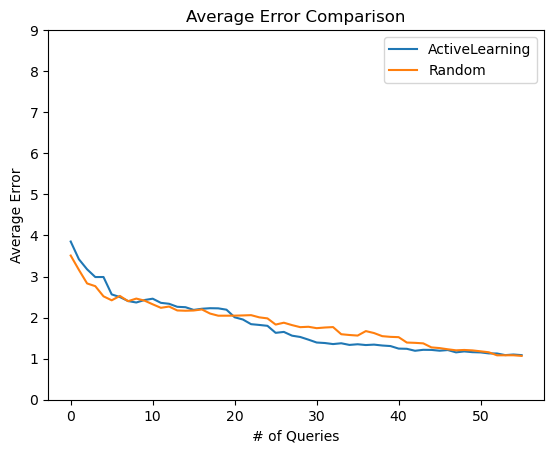

In [71]:
df1 = pd.read_csv('./ALresults/Al_500.csv')
df2 = pd.read_csv('./ALresults/Rd_500.csv')

print(df1.head())
df1 = df1[['averageError']]
df2 = df2[['averageError']]

plt.figure()
plt.plot(df1, label='ActiveLearning')
plt.plot(df2, label='Random')
plt.xlabel('# of Queries')
plt.ylabel('Average Error')
plt.title('Average Error Comparison')
plt.ylim(0,9)
#plt.xlim(0,100)
plt.legend()
plt.show()